In [169]:
import pandas as pd
import numpy as np
import tarfile
from skimage import io
import ml_02_pca
%reload_ext version_information
np.__version__, pd.__version__

('1.16.4', '0.24.2')

<h3>Einlesen der .tgz-Datei mithilfe von <I>tarfile</I></h3>

In [2]:
tar = tarfile.open("lfw-funneled.tgz")
#tar.extractall() #gefährlich, entpackt direkt alles

In [3]:
i = 0
for tarinfo in tar:
    print(tarinfo.name, "is", tarinfo.size, "bytes in size and is ", end="")
    if tarinfo.isreg():
        print("a regular file.")
    elif tarinfo.isdir():
        print("a directory.")
    else:
        print("something else.")
        
    i+=1
    if i == 20:
        break


lfw_funneled is 0 bytes in size and is a directory.
lfw_funneled/George_HW_Bush is 0 bytes in size and is a directory.
lfw_funneled/George_HW_Bush/George_HW_Bush_0001.jpg is 17691 bytes in size and is a regular file.
lfw_funneled/George_HW_Bush/George_HW_Bush_0002.jpg is 14895 bytes in size and is a regular file.
lfw_funneled/George_HW_Bush/George_HW_Bush_0003.jpg is 18220 bytes in size and is a regular file.
lfw_funneled/George_HW_Bush/George_HW_Bush_0004.jpg is 17493 bytes in size and is a regular file.
lfw_funneled/George_HW_Bush/George_HW_Bush_0005.jpg is 21517 bytes in size and is a regular file.
lfw_funneled/George_HW_Bush/George_HW_Bush_0006.jpg is 17631 bytes in size and is a regular file.
lfw_funneled/George_HW_Bush/George_HW_Bush_0007.jpg is 20535 bytes in size and is a regular file.
lfw_funneled/George_HW_Bush/George_HW_Bush_0008.jpg is 17979 bytes in size and is a regular file.
lfw_funneled/George_HW_Bush/George_HW_Bush_0009.jpg is 16926 bytes in size and is a regular file.

<h3>2a) Zwischenspeichern der Personen mit mindestens 70 Bildern</h3>

In [26]:
i = 0
popular = []
for tarinfo in tar:
    if tarinfo.isdir():
        person = tarinfo.name
        i = 0
    elif tarinfo.isreg() and tarinfo.name.endswith("jpg"):
        i += 1
    if i >= 70:
        if person not in popular:
            popular.append(person)
            print(person)
        

['lfw_funneled/Gerhard_Schroeder', 70]
['lfw_funneled/Gerhard_Schroeder', 70, 'lfw_funneled/George_W_Bush', 70]
['lfw_funneled/Gerhard_Schroeder', 70, 'lfw_funneled/George_W_Bush', 70, 'lfw_funneled/Donald_Rumsfeld', 70]
['lfw_funneled/Gerhard_Schroeder', 70, 'lfw_funneled/George_W_Bush', 70, 'lfw_funneled/Donald_Rumsfeld', 70, 'lfw_funneled/Tony_Blair', 70]
['lfw_funneled/Gerhard_Schroeder', 70, 'lfw_funneled/George_W_Bush', 70, 'lfw_funneled/Donald_Rumsfeld', 70, 'lfw_funneled/Tony_Blair', 70, 'lfw_funneled/Ariel_Sharon', 70]
['lfw_funneled/Gerhard_Schroeder', 70, 'lfw_funneled/George_W_Bush', 70, 'lfw_funneled/Donald_Rumsfeld', 70, 'lfw_funneled/Tony_Blair', 70, 'lfw_funneled/Ariel_Sharon', 70, 'lfw_funneled/Colin_Powell', 70]
['lfw_funneled/Gerhard_Schroeder', 70, 'lfw_funneled/George_W_Bush', 70, 'lfw_funneled/Donald_Rumsfeld', 70, 'lfw_funneled/Tony_Blair', 70, 'lfw_funneled/Ariel_Sharon', 70, 'lfw_funneled/Colin_Powell', 70, 'lfw_funneled/Hugo_Chavez', 70]


<h3>2b) Zwischenspeichern der Bilder der am häufigsten abgebildeten Personen</h3>

Je ein Bild wird für die Klassifikation beiseite gelegt.

Zuerst Zwischenspeichern der Namen der Bilddateien, nach Personen getrennt, in einer Liste von Listen

In [53]:
popular_b = False
picturenames = []
pct = []
for tarinfo in tar:
    if tarinfo.isdir() and tarinfo.name in popular:
        popular_b = True
    elif tarinfo.isdir() and tarinfo.name not in popular:
        # Falls ein eine viel abgebildete Person voranging ist popular_b true
        # In diesem Fall wird pct gespeichert
        if popular_b:
            picturenames.append(pct)
            pct = []
        popular_b = False

    if popular_b == True and tarinfo.name.endswith("jpg"):
        pct.append(tarinfo.name)
# Falls die letzte Person viel abgebildet wurde wird zur Sicherheit pct gespeichert
if popular_b:
    picturenames.append(pct)
    pct = []

In [54]:
for plist in picturenames:
    print(len(plist))

109
530
121
144
77
236
71


In [52]:
np.shape(io.imread("lfw_funneled/George_HW_Bush/George_HW_Bush_0001.jpg", as_gray=True))

(250, 250)

Ausschneiden eines einheitlichen zentralen Ausschnittes, der nur Augen und
Mund enthält. Skalierung der Bilder auf die Größe 32 × 32 und Planieren der Matrizen zu Arrays.

In [181]:
pictures = []
class_pictures = []

for plist in picturenames:
    pct = []
    for picturename in plist:
        # Zentralen Ausschnitt mit Augen und Mund auswählen, Parameter durch Probieren erzeugt
        picture = io.imread(picturename, as_gray=True)[75:175, 75:175]
        #picture = np.resize(picture, (32,32))  #Ergibt Müll, bzw. Streifen
        picture = picture.flatten()
        # Beiseitelegen des jeweils letzten Bildes
        if picturename == plist[-1]:
            class_pictures.append(picture)
        else:
            pct.append(picture)
    pictures.append(pct)

In [182]:
np.shape(class_pictures[0])

(10000,)

In [163]:
#io.imshow(class_pictures[0])

In [183]:
all_cnt = []
for plist in pictures:
    all_cnt.append(len(plist))
all_cnt

[108, 529, 120, 143, 76, 235, 70]

In [184]:
np.sum(all_cnt)

1281

<h3>2c) Anwenden der Hauptkomponentenanalyse aus Aufgabe 2_1 auf die Designmatrix
(Alle Trainingsbilder für alle Personen wurden als Zeilen in eine gemeinsame
Designmatrix kopiert).</h3>

Aneinanderketten der Bildarrays zu einer N x D Designmatrix.

In [185]:
design = np.zeros((2,np.shape(class_pictures[0])[0])) #Hilfsmatrix
for plist in pictures:
    #for picture in plist:
    design = np.concatenate((design, plist), axis=0)
design = design[2:,:]

In [186]:
np.shape(design)

(1281, 10000)

In [166]:
design

array([[0.18263922, 0.10021882, 0.09008314, ..., 0.57335412, 0.58511882,
        0.59072196],
       [0.34386392, 0.33680941, 0.29978118, ..., 0.7418898 , 0.74075098,
        0.74859412],
       [0.11873333, 0.12993255, 0.14756824, ..., 0.37886196, 0.3867051 ,
        0.38556627],
       ...,
       [0.00784314, 0.00784314, 0.01176471, ..., 0.67284745, 0.69245529,
        0.70029843],
       [0.09928314, 0.11496941, 0.13065569, ..., 0.5039502 , 0.50787176,
        0.5157149 ],
       [0.09854431, 0.10190039, 0.10216824, ..., 0.48847137, 0.49239294,
        0.49631451]])

Umwandeln der Matrix in ein Pandas Dataframe

In [187]:
df = pd.DataFrame.from_records(design)

Hauptkomponentenanalyse mit dem Modul aus Aufgabe 1

In [188]:
pc, ai, quadd = ml_02_pca.pca(df, 12)

In [189]:
np.shape(pc)

(12, 10000)

Darstellen der 12 berechneten Hauptkomponenten als Bilder

In [190]:
eg = []
for g in pc:
    eg.append(np.resize(g, (100,100)))

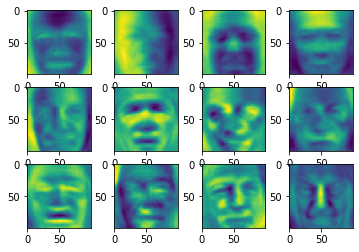

In [194]:
test = io.imshow_collection(eg)

In [5]:
tar.close()

In [7]:
%version_information numpy, pandas

Software versions
Python 3.7.3 64bit [MSC v.1915 64 bit (AMD64)]
IPython 7.6.1
OS Windows 10 10.0.18362 SP0
numpy 1.16.4
pandas 0.24.2
Mon Nov 04 08:33:51 2019 Mitteleuropäische Zeit